# How to Develop a 1D GAN from Scratch

In this notebook I will be making notes and commenting on the code from https://datahacker.rs/006-gans-how-to-develop-a-1d-gan-from-scratch/ which gives a step by step guide on how GANs can be implemented using PyTorch. The example we will be using is a sine wave.

## What is a GAN?

A GAN consists of having two deep neural networks called the Generator and the Discriminator. The Gan also uses real data samples and the goal of the Generator is to try and replicate samples from the real dataset to create new unseen images. These images are then fed into the Discriminator. Both the Generator and the Discrimator will work together to optimise one another.

First we need to import the relevant libraries which are PyTorch and matplotlib

In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
training_steps = 50000    
samples = 200
epochs = 1000 #number of epochs
n = 100 #number of batches to be created
numb_input_layer = 5
training_steps = 50000    


Next we have to define a 1D function that we want ot model with the GANs. The input will be x data variables and the true data will be created from the sine function. If the outputted y plot is the same as the sine function then it wil be regarded as a true data label, if not then it will be judged as a fake data point. The job of the Generator is try to learn what causes a y variable to be true or not.

Below we will create a sine function which takes an x input and will output the corresponding floating point y for that input. This can be tested with some example inputs.

In [3]:
def sine_function(x):
    return torch.sin(x)

# test sine_function()    
print(sine_function(torch.tensor(torch.pi * 0.5 )))
print(sine_function(torch.tensor(torch.pi * 0. )))

tensor(1.)
tensor(0.)


In [4]:
def tan_function(x):

    return torch.tan(x)

In [5]:
def cos_function(x):

    return torch.cos(x)

In [26]:
def function_picker(x):

    #return sine_function(x)
    return cos_function(x)
    #return tan_function(x)

Next we will create the random x variables that will be used and find the corresponding y points for these x inputs. We can then plot this to show our sine wave

Text(0.5, 1.0, 'Plot of our sine wave')

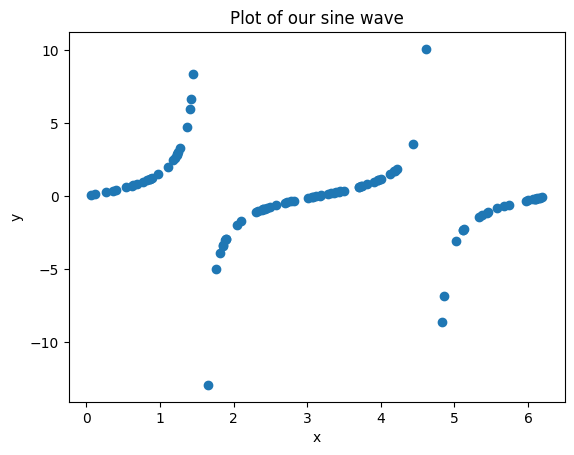

In [7]:
x = torch.rand(100) * 2 * torch.pi

y = function_picker(x)
# plot the sine wave function
plt.scatter(x.numpy(), y.numpy())

plt.xlabel("x")
plt.ylabel("y")
plt.title('Plot of our sine wave')

Now we can create the function that will be used to generate data samples. When creating a proper model these will come from a dataset for example a set of images. This function should not only return the variable but also return the label. As all of these are real labels they should all be returned with the label 1.

In [8]:
def generate_data_samples(n):
    # here we define the number of n numbers from a Uniform distribution
    x1 = torch.rand(n) * 2 * torch.pi
    x2 = function_picker(x1)
    x1 = x1.view(n,1)
    x2 = x2.view(n,1)
    y_data = torch.ones((n,1))

    return torch.hstack((x1, x2)), y_data

Now we can create the test data using the above function. We will create 100 test datapoints.

Text(0.5, 1.0, 'Plot of our test data sine wave')

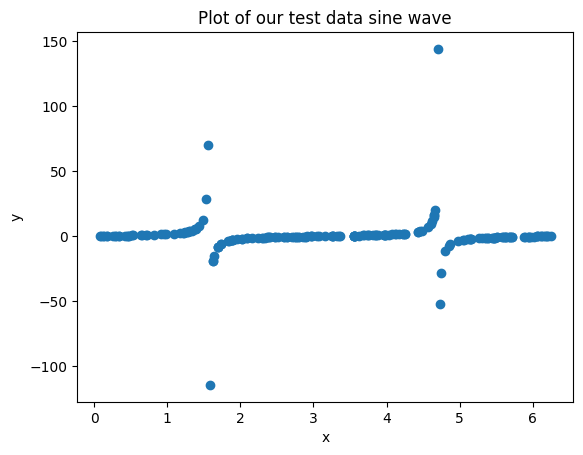

In [9]:
test_generated_data = generate_data_samples(samples)

plt.scatter(test_generated_data[0][:,0].numpy(), test_generated_data[0][:,1].numpy())
plt.xlabel("x")
plt.ylabel("y")
plt.title('Plot of our test data sine wave')

To develop the Generator we will develop a simple model. We ill assume that is is a neural network which has fully connected layers. We will use an input that is a vector that is equal to 5. This menas that we want to develop a generator whose input is a random vector of 5 elements. Al the output we ewant to get two elements, where the second one models the function

The discrimator will also be a neural netowrk. The input vector will be of size 2. The input vectors will come from the read data or the fake generated dataset which uses the generator model. The discrimator should distinguish between the real data (1) and the fake data(0).

To define the discriminator model we will create a simple neural network. An input to this network will be a 2 dimensional vector that has the x and sine(x) of that x.

The goal of the discriminator is to distinguish between the real and fake data samples. Now we will also create a function that will create 'dummy' fake data. This function will create a pair of x and y numbers that are completely random. The discriminator network will have a simple output as it will be a simple binary classification problem

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #hidden layer has 25 neurons
        self.fc1 = nn.Linear(2, 25)
        #output layer only has 1 neuron as it is either 1 or 0
        self.fc2 = nn.Linear(25,1)

    def forward(self,x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

We can do a sanity check at this stage to check that the discrimator is working. We can pass in a random 2 element vector.

In [11]:
discriminator = Discriminator()
# test a discriminator with a simple input - sanity check
x_data_test = torch.rand(2)
discriminator(x_data_test)

tensor([0.5737], grad_fn=<SigmoidBackward0>)

We need to create something that will train the discriminator. To do this we need to create a fake dummy dataset. The two random variables will make an input pair that the discriminator has to distinguish.

In [12]:
def generate_dummy_fake_data(n):
    x1 = torch.rand(n) * 2 * torch.pi
    x2 = torch.rand(n) * 2 * torch.pi
    x1 = x1.view(n,1)
    x2 = x2.view(n,1)
    y_fake = torch.zeros((n,1))
    return torch.hstack((x1, x2)), y_fake

We can plot the fake data below

Text(0.5, 1.0, 'Plot of our fake data')

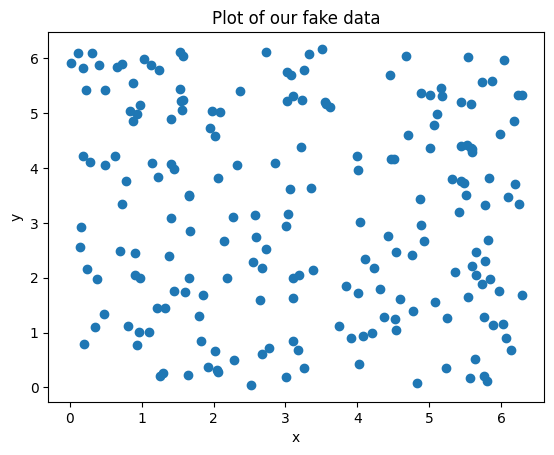

In [13]:
x_fake,y_fake = generate_dummy_fake_data(samples)
plt.scatter(x_fake[:, 0].numpy(),x_fake[:, 1].numpy())
plt.xlabel("x")
plt.ylabel("y")
plt.title('Plot of our fake data')

Now that we have our dummy data and real data we can now start to train the discriminator. We can use a standard Pytorch frameowrk for the training of the neural network. We will use the Adam algorithm.

In [14]:
discriminator = Discriminator()
optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.001) 
criterion = torch.nn.BCELoss()

Here we can define the number of epochs that we would like to have and the size of the batches. The batch size will be used to create n numbre of real and fake datasets.

In [15]:

x_data, y_data = generate_data_samples(n)
x_fake, y_fake = generate_dummy_fake_data(n)

x_all = torch.vstack((x_data, x_fake))
y_all = torch.vstack((y_data, y_fake))
all_loss = []
for i in range(epochs):
    y_hat = discriminator(x_all)
    loss = criterion(y_hat, y_all)
    all_loss.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

The rest of the code above is concatenating the real and the fake data into a single variable as well as their labels. This combined variable is then passed into the discriminator. A loss function is then used to differentiate the desired ouptut with the networks output. The network then uses backpropogationa and gradient descent to optimise the model.

Below we can plot the loss after each epoch. We should see it descreaing with a reduced gradient after each epoch until it nearly platos.

Text(0.5, 1.0, 'Plot of the loss after each epoch')

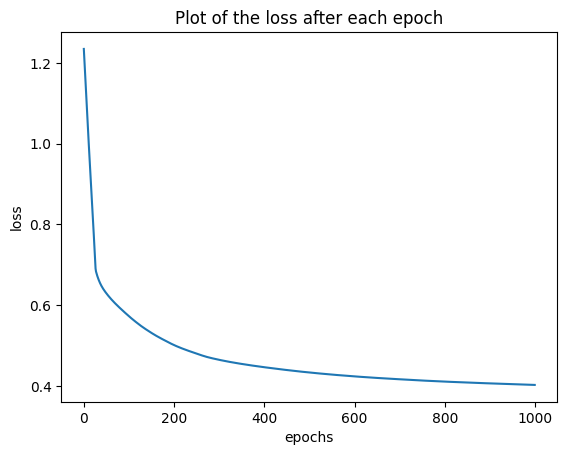

In [16]:
plt.plot(all_loss)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('Plot of the loss after each epoch')

## Defining a Generative Model

The architecture of the generative model should be somwehat symmetrical as compared with the discriminator. Below we will implement a generator using a shallow neural network.

In [17]:
# define a Generator Model

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(5,15)
        self.fc2 = nn.Linear(15, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        # note that here we are not adding any activation functions
        # since we assume the linear output as the values can be negative as well
        # in other words this activation function here is just an "identity function" f(x)=x
        return x

Here we have defined a 5 neuron input layer and a hidden layer of 15 neurons. The output layer has 2 neurons and we have opted for a ReLu activatoin function. The output has 2 neurons as it outputs the x and the corresponding sin(x). We can do a sanity check below to check it has been implemented correclty. Our desired output is:

'tensor([ 0.1416, -0.1184], grad_fn=<AddBackward0<AddBackward0>>)'


In [18]:
generator = Generator()
test_generator = generator(torch.rand(numb_input_layer))
print(test_generator)

tensor([-0.0051,  0.2362], grad_fn=<ViewBackward0>)


We see that it outputs a vector with two elements. Since the current weights are randomly initialized, we do not expect any meaningful result at the output so far. We still need to reach the GAN training phase for this. 

## Generating fake data

In our next steps we will be creating the fake data. Our input will be a latent vector (z) of dimension 5. Then this v3ector will be used as the input to the generator which will output a 2 element column vector. We also want to create a full bactch of such data samples. To do this we need to create a function to do so

In [19]:
def generate_latent_points(n, latent_dim=5):
    # here we will assume that in the z-space 
    # or latent space we have 5 dimensional random vector 
    z = torch.rand(n*latent_dim)
    return z.view((n,latent_dim))

a = generate_latent_points(10)
print(a)

tensor([[0.7062, 0.0848, 0.6027, 0.2649, 0.5669],
        [0.0917, 0.1886, 0.3293, 0.7310, 0.1180],
        [0.1146, 0.8115, 0.7255, 0.1201, 0.6570],
        [0.0710, 0.2396, 0.0555, 0.8083, 0.7463],
        [0.5193, 0.4053, 0.0513, 0.5484, 0.5725],
        [0.8533, 0.5278, 0.7642, 0.2603, 0.2231],
        [0.6312, 0.9303, 0.8792, 0.3451, 0.3040],
        [0.8323, 0.8421, 0.0391, 0.1884, 0.2761],
        [0.7344, 0.6516, 0.4568, 0.8331, 0.2802],
        [0.1470, 0.2786, 0.3905, 0.4698, 0.3878]])


As seen the data is structured as a matrix of sie 5n. This latent vercotr should be passed through the generator and this will create the fake data

In [20]:
def generate_fake_samples(generator, n, latent_dim=5):
    z = generate_latent_points(n)
    fake_data = generator(z)
    return fake_data 

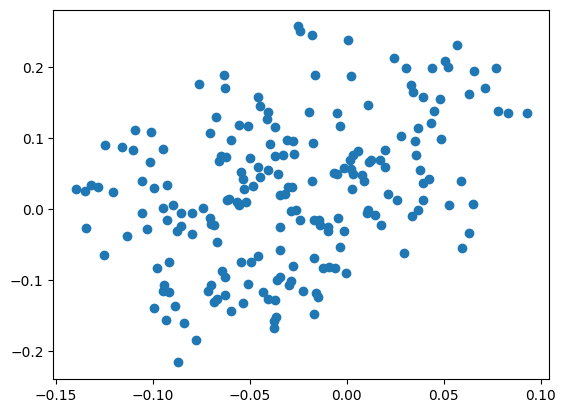

In [21]:
fake_data_test = generate_fake_samples(generator, samples)
plt.scatter(fake_data_test[:,0].detach().numpy(), fake_data_test[:,1].detach().numpy())

Here we have plotted 100 elements for the fake data generated. The dataset is created when the generator neural networks is initialised with the random weight values. These fake values will gradually start to resemble the real data as it is trained more and more

Now we need to train the GAN which means we have to train the generator and the discriminator simultaneously. Below is the implementation

Now that we have trained the generator model we can now take this output data and pass it into the discriminator. However we will now label this dat as 'real data' to mix it with the actual real data. Therefore the discriminator has to work out for itself which data is real or fake.

Now we need to train the discriminator

We will train the discriminator by using both the fake and the real data. There is no need to perform invertinghere so we will use the class labels that are set to 0

Once this is complete we will now train using the real dataset whole class labels are set t o1. When we pass fake data samples to a dscriminator we will use a function .detach(). In this way, we will turn off gradient calculations and this dat will be treated as a constant data values

The loss function is a simple division by 2

We will then use backpropogation

In [22]:

# Models
generator =     Generator()
discriminator = Discriminator()

# Optimizers
generator_optimizer     = torch.optim.Adam(generator.parameters(),     lr=0.001)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

# loss
loss = nn.BCELoss()
gLosses = []
dLosses = []

N = 128

for i in range(training_steps):
    # zero the gradients on each iteration
    generator_optimizer.zero_grad()
    if i%5000 ==0:
        print(f"{i} \n")

    # Create a fake data with a generator
    fake_data = generate_fake_samples(generator, N)

    # here we define the INVERSE labels for fake data
    fake_data_label = torch.ones(N,1)

    # Generate examples of real data
    real_data, real_data_label = generate_data_samples(N)
    
    # Train the generator
    # We invert the labels here and don't train the discriminator because we want the generator
    # to make things the discriminator classifies as true.
    generator_discriminator_out = discriminator(fake_data)
    generator_loss = loss(generator_discriminator_out, fake_data_label)
    generator_loss.backward()
    generator_optimizer.step()

    # Train the discriminator on the true/generated data
    discriminator_optimizer.zero_grad()
    true_discriminator_out = discriminator(real_data)
    true_discriminator_loss = loss(true_discriminator_out, real_data_label)

    # here a fake_data is passed with a gradient turned off
    # see our post about <a href="https://datahacker.rs/004-computational-graph-and-autograd-with-pytorch/#Automatic-differentiation-module-in-PyTorch---Autograd">AUTOGRAD</a>
    generator_discriminator_out = discriminator(fake_data.detach())
    generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros(N,1))
    discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
    discriminator_loss.backward()
    discriminator_optimizer.step()

    gLosses.append(generator_loss.item())
    dLosses.append(discriminator_loss.item())

0 

5000 

10000 

15000 

20000 

25000 

30000 

35000 

40000 

45000 



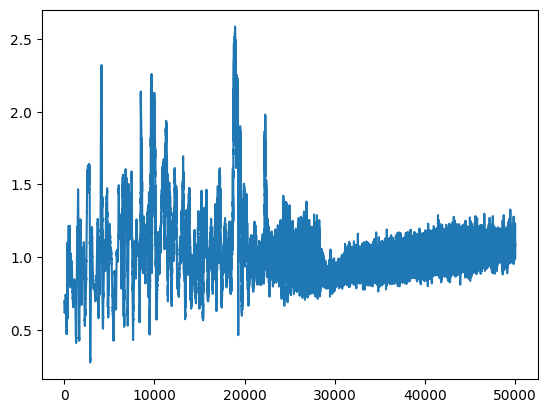

In [23]:
plt.plot(gLosses,label="G")


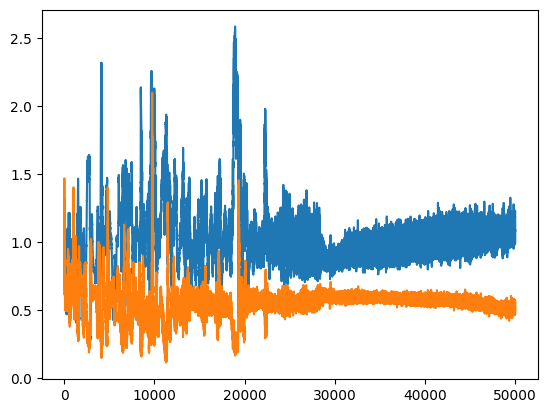

In [24]:
plt.plot(gLosses,label="G")
plt.plot(dLosses,label="D")


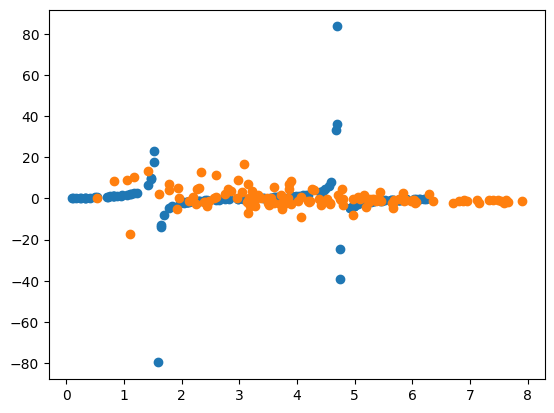

In [25]:
plt.scatter(real_data[:,0].detach().numpy(), real_data[:,1].detach().numpy())
plt.scatter(fake_data[:,0].detach().numpy(), fake_data[:,1].detach().numpy())

Now that the training phase is over, we can use the generator to create a new batch size for us. This has now been plotted above as the orange data points and the real data points being blue.